In [90]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# Helper functions

In [91]:

def log_prior(model, theta_mu=None, sigma=None):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }},
                  'MyPeriodicKernel':{'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = list()
    covar_string = gsr(model.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(model.named_parameters(), covar_string_list):
        params.append(param.item())
        debug_param_name_list.append(param_name)
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            theta_mu.append(prior_dict["noise"]["raw_noise"]["mean"])
            variances_list.append(prior_dict["noise"]["raw_noise"]["std"])
            continue
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = False
            else:
                try:
                    theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                    variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                except Exception as E:
                    import pdb
                    pdb.set_trace()
                    prev_cov = cov_str
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)

def optimize_hyperparameters(model, likelihood, train_iterations, X, Y, with_BFGS=False, MAP=False, prior=None, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    ## Setup
    # Log the parameters found during training
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    best_loss = 1e400
    optimal_parameters = dict()
    limits = hyperparameter_limits
    if log_param_path:
        param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
    if log_likelihood:
        likelihood_log = list()
    # start runs
    for iteration in range(random_restarts):
    #for iteration in range(2):
        # optimize and determine loss
        # Perform a training for AIC and Laplace
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(train_iterations):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            if MAP:
                log_p = log_prior(model)
                loss -= log_p
            loss.backward()
            optimizer.step()
            if log_param_path:
                for param_name in model.named_parameters():
                    param_log_dict[param_name[0]].append(param_name[1][0].item())
            if log_likelihood:
                likelihood_log.append(loss.item())

        if with_BFGS:
            # Additional BFGS optimization to better ensure optimal parameters
            # LBFGS_optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50, line_search_fn='strong_wolfe')
            LBFGS_optimizer = torch.optim.LBFGS(
                model.parameters(), max_iter=50,
                line_search_fn='strong_wolfe')
            # define closure

            def closure():
                LBFGS_optimizer.zero_grad()
                output = model(X)
                loss = -mll(output, Y)
                if MAP:
                    log_p = log_prior(model)
                    loss -= log_p
                LBFGS_optimizer.zero_grad()
                loss.backward()
                if log_param_path:
                    for param_name in model.named_parameters():
                        param_log_dict[param_name[0]].append(param_name[1][0].item())
                if log_likelihood:
                    likelihood_log.append(loss.item())
                return loss
            LBFGS_optimizer.step(closure)

        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, Y)
        if MAP:
            log_p = log_prior(model)
            loss -= log_p

#        model.train_model(with_BFGS=with_BFGS)
        current_loss = loss
        # check if the current run is better than previous runs
        if current_loss < best_loss:
            # if it is the best, save all used parameters
            best_loss = current_loss
            for param_name, param in model.named_parameters():
                optimal_parameters[param_name] = copy.deepcopy(param)

        # set new random inital values
        model.likelihood.noise_covar.noise = torch.rand(1) * (limits["Noise"][1] - limits["Noise"][0]) + limits["Noise"][0]
        #self.mean_module.constant = torch.rand(1) * (limits["Mean"][1] - limits["Mean"][0]) + limits["Mean"][0]
        for kernel in get_kernels_in_kernel_expression(model.covar_module):
            hypers = limits[kernel._get_name()]
            for hyperparameter in hypers:
                new_value = torch.rand(1) * (hypers[hyperparameter][1] - hypers[hyperparameter][0]) + hypers[hyperparameter][0]
                setattr(kernel, hyperparameter, new_value)

        # print output if enabled
        if options["training"]["print_optimizing_output"]:
            print(f"HYPERPARAMETER OPTIMIZATION: Random Restart {iteration}: loss: {current_loss}, optimal loss: {best_loss}")

    # finally, set the hyperparameters those in the optimal run
    model.initialize(**optimal_parameters)
    output = model(X)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss = -mll(output, Y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    if not loss == best_loss:
        import pdb
        pdb.set_trace()
        print(loss)
        print(best_loss)
    if log_param_path:
        logables = {"training_log": param_log_dict, "likelihood_log": likelihood_log}
        return loss, logables
    return loss

In [92]:
def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + res[0])
        new_unit_y.append(mu[1] + res[1])
    return new_unit_x, new_unit_y

# Pre-diddling

In [93]:
# Globals
figure_path = "periodic_figures"

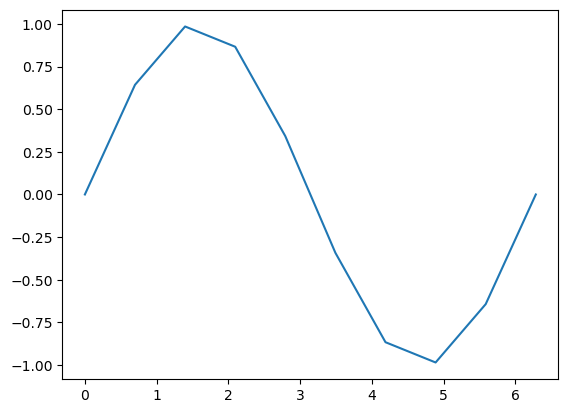

In [94]:
END = 2*np.pi 
COUNT = 10
train_x = torch.linspace(0, END, COUNT)
train_y = torch.sin(train_x)
plt.plot(train_x, train_y)

In [95]:
import torch
from typing import Optional

from gpytorch.constraints import Interval, Positive
from gpytorch.priors import Prior
from gpytorch.kernels import Kernel

import math
class MyPeriodicKernel(Kernel):
    def __init__(
        self,
        period_length_prior: Optional[Prior] = None,
        period_length_constraint: Optional[Interval] = None,
        **kwargs,
    ):
        super(MyPeriodicKernel, self).__init__(**kwargs)
        self.has_lengthscale = False
        if period_length_constraint is None:
            period_length_constraint = Positive()

        ard_num_dims = kwargs.get("ard_num_dims", 1)
        self.register_parameter(
            name="raw_period_length", parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, ard_num_dims))
        )

        if period_length_prior is not None:
            if not isinstance(period_length_prior, Prior):
                raise TypeError("Expected gpytorch.priors.Prior but got " + type(period_length_prior).__name__)
            self.register_prior(
                "period_length_prior",
                period_length_prior,
                lambda m: m.period_length,
                lambda m, v: m._set_period_length(v),
            )

        self.register_constraint("raw_period_length", period_length_constraint)

    @property
    def period_length(self):
        return self.raw_period_length_constraint.transform(self.raw_period_length)

    @period_length.setter
    def period_length(self, value):
        self._set_period_length(value)

    def _set_period_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_period_length)
        self.initialize(raw_period_length=self.raw_period_length_constraint.inverse_transform(value))

    def forward(self, x1, x2, diag=False, **params):
        # Pop this argument so that we can manually sum over dimensions
        last_dim_is_batch = params.pop("last_dim_is_batch", False)

        x1_ = x1.div(self.period_length / math.pi)
        x2_ = x2.div(self.period_length / math.pi)
        # We are automatically overriding last_dim_is_batch here so that we can manually sum over dimensions.
        diff = self.covar_dist(x1_, x2_, diag=diag, last_dim_is_batch=True, **params)

        exp_term = diff.sin().pow(2.0).div(1.0).mul(-2.0)

        if not last_dim_is_batch:
            exp_term = exp_term.sum(dim=(-2 if diag else -3))

        return exp_term.exp()

# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.covar_module = MyPeriodicKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [96]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.raw_period_length',
  Parameter containing:
  tensor([[0.]], requires_grad=True))]

In [98]:
num_train_iter = 600
# Train the MAP for X Iterations of ADAM and then max 50 more of L-BFGS
loss, training_log = optimize_hyperparameters(model, likelihood, num_train_iter, train_x, train_y, True, MAP=True, log_param_path=True, random_restarts=1, log_likelihood=True)

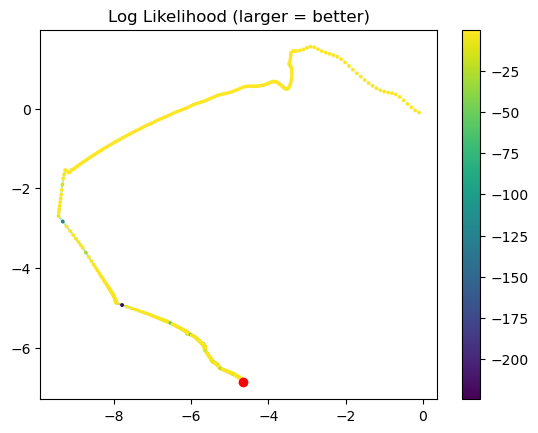

In [ ]:
#plt.plot(training_log["training_log"]['likelihood.noise_covar.raw_noise'])
#plt.plot(training_log["likelihood_log"])
param_keys = list(training_log["training_log"].keys())
filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(training_log["training_log"][param_keys[0]], training_log["training_log"][param_keys[1]], training_log["likelihood_log"]):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
else:
    for i in range(len(training_log["training_log"][param_keys[0]])-1):
        n, l = training_log["training_log"][param_keys[0]][i], training_log["training_log"][param_keys[1]][i]
        n2, l2 = training_log["training_log"][param_keys[0]][i+1], training_log["training_log"][param_keys[1]][i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(training_log["training_log"][param_keys[0]])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(training_log["training_log"][param_keys[0]], training_log["training_log"][param_keys[1]], c=-torch.Tensor(training_log["likelihood_log"]), s=3)
plt.title("Log Likelihood (larger = better)")
plt.colorbar()

plt.plot(training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1], "ro") 


In [ ]:
with torch.no_grad():
    observed_pred_prior = likelihood(model(model.train_inputs[0]))

like_cov_chol = torch.linalg.cholesky(observed_pred_prior.covariance_matrix)
like_dist = torch.distributions.multivariate_normal.MultivariateNormal(observed_pred_prior.mean, scale_tril=like_cov_chol)
print(like_dist.log_prob(model.train_targets))
print(-training_log["likelihood_log"][-1]*COUNT)

tensor(-11.4654)
-22.86818027496338


In [ ]:
print(f"L-BFGS iterations: {len(training_log['likelihood_log']) - num_train_iter}")

lap, lap_log = metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term=-1.0)
print(lap)
print(lap_log)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

scaling_factor = lap_log["neg MLL"]
mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
K = lap_log["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, K)
plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
K = lap_log["original symmetrized Hessian"]
try:
    new_unit_x, new_unit_y = get_std_points(mu, K)
    plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
except Exception as E:
    print(E)



L-BFGS iterations: 11
tensor(-5.2869, dtype=torch.float64, grad_fn=<AddBackward0>)
{'neg MLL': tensor(2.2868, grad_fn=<NegBackward0>), 'punish term': tensor(-3.0001, dtype=torch.float64), 'punish without replacement': tensor(22.5018, dtype=torch.float64), 'laplace without replacement': tensor(20.2150, dtype=torch.float64, grad_fn=<SubBackward0>), 'num_replaced': tensor(3), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_lengthscale', 'covar_module.raw_period_length'], 'Jacobian': (tensor([0.0026], grad_fn=<SoftplusBackwardBackward0>), tensor([[4.8325e-11]], grad_fn=<SoftplusBackwardBackward0>), tensor([[-1.4987e-08]], grad_fn=<AddBackward0>)), 'parameter values': tensor([[-4.6650],
        [-6.8594],
        [-0.7065]]), 'corrected Hessian': tensor([[ 4.6427e+01, -3.9937e-22,  5.0466e-22],
        [-4.0056e-22,  4.6427e+01, -1.6877e-15],
        [ 7.1473e-22, -1.6877e-15,  4.6427e+01]], dtype=torch.float64), 'diag(constructed eigvals)': tensor([46.4268, 46.4268

ValueError: Dimension mismatch: array 'cov' is of shape (3, 3), but 'mean' is a vector of length 2.

In [ ]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 10000, log_param_path=True, log_full_likelihood=True)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1_kmyuvv/model_gp7chtc2.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_1_kmyuvv/model_gp7chtc2.stan', line 32, column 97 to
    column 105, the value of v depends on parameter(s): theta.
Warning in '/tmp/httpstan_1_kmyuvv/model_gp7chtc2.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_1_kmyuvv/model_gp7chtc2.stan', line 32, column 51 to
    column 59, the value of v depends on parameter(s): theta.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/11000)
Sampling: 100% (11000/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 

{'mu': tensor([[-3.5164],
        [-0.2122]]), 'var': tensor([[12.8388,  0.0000],
        [ 0.0000,  3.5704]])}


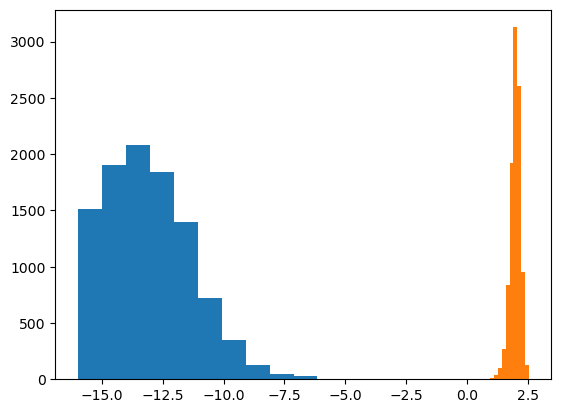

In [ ]:
#

for param_name in MC_log['param draws dict']:
    plt.hist(MC_log['param draws dict'][param_name])
print(MC_log["Parameter prior"])
plt.savefig(f"{figure_path}/MCMC_param_distribution_{COUNT}_datapoints.png")

Text(0.5, 1.0, 'Log Likelihood')

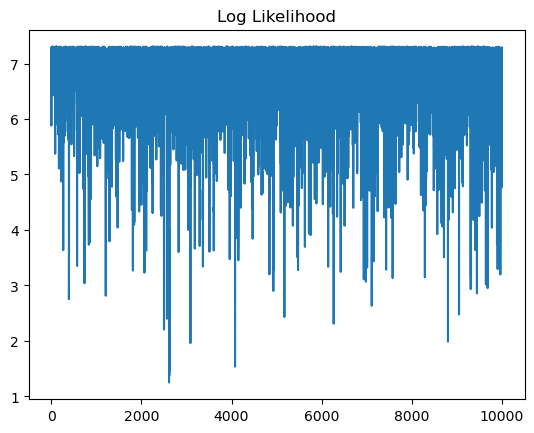

In [ ]:
plt.plot(MC_log['manual lp list'])
plt.title("Log Likelihood")

In [ ]:
MC_log["Parameter statistics"]

{'theta.1': {'mu': -13.109641023641796, 'var': 3.0642489980763794},
 'theta.2': {'mu': 1.9859172054420378, 'var': 0.04358203347019802}}

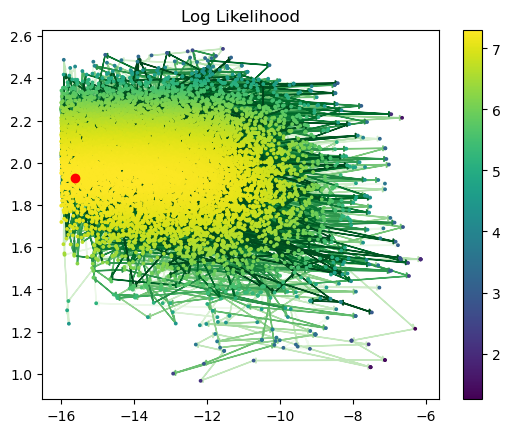

In [ ]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

filtered = False
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], MC_log['manual lp list']):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
else:
    for i in range(len(MC_log['param draws dict']["theta.1"])-1):
        n, l = MC_log['param draws dict']["theta.1"][i], MC_log['param draws dict']["theta.2"][i]
        n2, l2 = MC_log['param draws dict']["theta.1"][i+1], MC_log['param draws dict']["theta.2"][i+1]
        plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict']["theta.1"])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], c=torch.Tensor(MC_log['manual lp list']), s=3)
    max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
    plt.plot(MC_log['param draws dict']["theta.1"][max_index], MC_log['param draws dict']["theta.2"][max_index], "ro")
plt.title("Log Likelihood")
plt.colorbar() 


Text(0.5, 1.0, 'Log Log Likelihood')

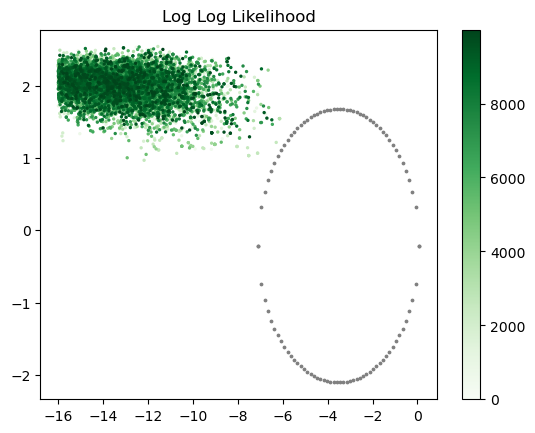

In [ ]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], MC_log['manual lp list']):
    if llik > -5000:
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict']["theta.1"], MC_log['param draws dict']["theta.2"], c=range(len(MC_log['param draws dict']["theta.2"])), cmap="Greens", s=2)
plt.colorbar() 
new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0], MC_log["Parameter prior"]["var"])
# Draw one standard deviation around the center of the distribution
plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)
plt.title("Log Log Likelihood")